In [10]:
'''
Hi there. See each cell for short comments. The full report is given in separate file. 

Here's the summary of cell contents in this file:
    0: Import packages
    1: Load data, transform
    2: Inspect and split to test and train sets
    3: Just a little more transformation of training and testing sets.
    4: Setting up Word2Vector model and embedding matrix.
    5: Same but also inspecting sentence length distribution to adjust embedding matrix.
    6: Model definition, training and saving
    7: Classification report
    8: History plotting
    9: Confusion matrix
    10: Test it yourself! Run first all the cells but the training.
    Unfortunately, due to sensitive nature of the data, this file cannot be run. However, I attached another file
    "TEST_THE_MODEL.ipynb"
    where you can test and try the model with your own service requests. Cheers!
    
    ---- Kosti Koistinen, 2023 ----

    PS. Note that the model is trained with Finnish data. Therefore, it will not understand English.
'''
from datetime import datetime
import keras
import sys
import numpy as np
from keras.models import load_model
import random
import copy
import sys
import pandas as pd
from datetime import datetime
import seaborn as sns
import pandas as pd
import os
!pip install xlrd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from gensim.models import word2vec
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.regularizers import l2


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\koistkos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [131]:
'''

Order of the cells:
    1: Load data, transform
    2: Inspect and split to test and train sets (20/80)
    3: Just a little more transformation of training and testing sets.
    4: Setting up Word 2 vector model and embedding matrix.
    5: Same but also inspecting sentence length distribution to adjust embedding matrix.
    6: Model training and saving
    7: Classification report
    8: History plotting
    9: Confusion matrix
    10: Test it yourself! Run first all the cells but the training.
'''
# Read and modify the data. Data is in a folder called MEITA (next to root).
# All the files from the folder are read.
i=0
filenames = os.listdir('MEITA')
while i<len(filenames): # Read values and concatenate them into one big dataframe.
    df = pd.read_excel('MEITA/'+filenames[i], usecols=['Aihe', 'Kategoria'])
    if i == 0:
        df1 = copy.deepcopy(df)
        df1.reset_index(drop=True, inplace=True)
        i=i+1
        continue
    else:
        #Concatenate array
        df1 = pd.concat([df1, df], axis=0)
        # Reset indexing
        df1.reset_index(drop=True, inplace=True)
    i=i+1
pd.set_option('display.max_rows', 100)
#Lower case everything and remove punctuations!
df1['Aihe'] = df1['Aihe'].str.lower()
df1['Aihe'] = df1['Aihe'].replace('[^\w\s]', '', regex=True)
df1['Aihe'] = df1['Aihe'].replace('\d+', '', regex=True)
df1 = df1.fillna('')

#--------------------------------------------------- Sort the data frame by frequency. Then copy it to original.
value_counts = df1['Kategoria'].value_counts()

# create a new DataFrame that is sorted by occurrences
df_sorted = df1.assign(count = df1['Kategoria'].map(value_counts)).sort_values('count', ascending=False)

# if you want to drop the count column
df_sorted = df_sorted.drop(columns='count')
df_sorted.reset_index(drop=True, inplace=True)
nan_count = df_sorted.isna().sum()
#------------------------------------------------- Copy, then count the frequency of categories
df1 = df_sorted.copy()
category_counts = df1['Kategoria'].value_counts()
#------------------------------------------------Check if category has less than thousand values? If so, combine them to group "Muut"
i=0
poistonimi = []
while i<len(category_counts):
    if category_counts[i]<1000:
        
        new_index = [index if count >= 1000 else 'Muut' for index, count in category_counts.items()]
        # Create new series with updated index
        
        poistonimi=np.append(poistonimi,category_counts.index[i])
    i=i+1
category_counts = pd.Series(category_counts.values, index=new_index)
category_counts = category_counts.groupby(level=0).sum()
category_counts = category_counts.sort_values(ascending=False)
category_order = category_counts.index.tolist()
i=0
while i<len(poistonimi):
    df1 = df1.replace(poistonimi[i],"Muut")
    i=i+1

df1 = df1.sort_values(by='Kategoria', 
                      key=lambda x: x.map({val: i for i, val in enumerate(category_order)}))
#------------------------------------------------------------------------------------------------ Just some fine tuning.
#pd.set_option('display.max_rows', 1000)
df1 = df1.dropna()
df1.reset_index(drop=True, inplace=True)
df2 = pd.factorize(df1['Kategoria'])[0]
df1['Category'] = df2
categorynames = df1['Kategoria'].unique().tolist()
pd.set_option('display.expand_frame_repr', False)

df.style.background_gradient(cmap='coolwarm')
display(df1)

categorynames = df1['Kategoria'].unique().tolist()
num_cat = len(categorynames)

pd.set_option('display.max_rows', num_cat)
print(df1['Kategoria'].value_counts() )
print("Kategoriat:", categorynames)
with open("Kategoriat.txt", "w",encoding="UTF-8") as f:
    # Write each element of the list to a new line in the file
    for item in categorynames:
        f.write(item + "\n")

#Drop kategoria, keep only the category index.
df1.drop('Kategoria', axis=1, inplace=True)
data = df1.to_numpy()
unique_categories = np.unique(data[:,1])
num_cat = len(unique_categories)
print("Number of categories: ", num_cat)
df1.columns = ["teksti","category"]

,Aihe,Kategoria,Category
0,tunnusten kiirehdintä,Käyttöoikeudet,0
1,mediatri salasanan vaihto,Käyttöoikeudet,0
2,mediatri salasanan vaihto,Käyttöoikeudet,0
3,mediatri salasanan vaihto,Käyttöoikeudet,0
4,mediatri salasanan vaihto,Käyttöoikeudet,0
...,...,...,...
61469,sähköposti ei toimi kesätaipaleella,Tietoliikenne,10
61470,tulostimen kytkentä verkkoon,Tietoliikenne,10
61471,verkko ei toimi,Tietoliikenne,10
61472,palomuuriavaus,Tietoliikenne,10


Kategoria
Käyttöoikeudet         20183
Järjestelmäpalvelut    14210
Työasemasovellus        7257
Työasemat               6436
Oheislaitteet           2887
Mobiililaite            2644
Muut                    1918
Puhelinpalvelut         1815
Etäyhteydet             1752
Elinkaari               1288
Tietoliikenne           1084
Name: count, dtype: int64
Kategoriat: ['Käyttöoikeudet', 'Järjestelmäpalvelut', 'Työasemasovellus', 'Työasemat', 'Oheislaitteet', 'Mobiililaite', 'Muut', 'Puhelinpalvelut', 'Etäyhteydet', 'Elinkaari', 'Tietoliikenne']
Number of categories:  11


Size of training data (49179,)
Size of testing data (12295,)


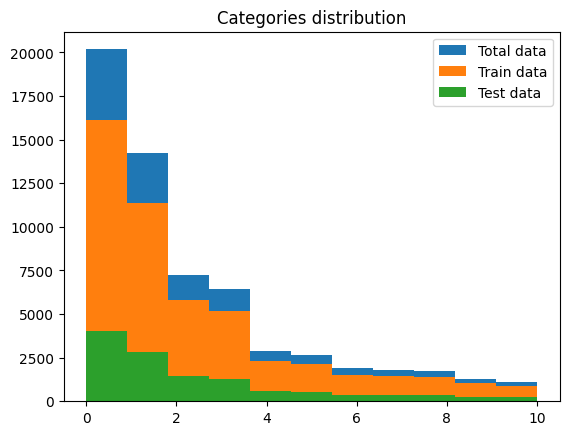

In [128]:
#Inspect data. Split the training sets.
plt.hist(data[:,1], label="Total data", bins=num_cat)
plt.title("Categories distribution")

# Split the data into training and testing sets while maintaining the class proportions
X_train, X_test, y_train, y_test = train_test_split(data[:,0], data[:,1], test_size=0.2, 
                                                    stratify=data[:,1], random_state=42, shuffle=True)


print("Size of training data", np.shape(X_train))
print("Size of testing data",  np.shape(X_test))
plt.hist(y_train, label= "Train data", bins=num_cat)
plt.hist(y_test, label="Test data", bins=num_cat)
plt.legend()
plt.savefig("histocate.png")
plt.show()

In [115]:

data = {'text': X_test, 'teksti': y_test}
test_data = pd.DataFrame(data)
Uusi = np.transpose(np.vstack((X_train, y_train)))
np.savetxt("test.txt",Uusi,fmt='%s', encoding='utf-8', delimiter = '\t') #Saving the numpy array and then reading it makes it easier to parse data
train_data = pd.read_csv('test.txt', sep='\t', on_bad_lines = 'warn', names=['text', 'teksti'])

# Train Data Labels
train_data["teksti"] = train_data["teksti"].astype('category')
train_data["teksti_label"] = train_data["teksti"].cat.codes
train_features, train_labels = train_data['text'], tf.one_hot(
    train_data["teksti_label"], num_cat)
print(train_features)
train_features = train_features.str.lower()
# Test Data Labels
test_data["teksti"] = test_data["teksti"].astype('category')
test_data["teksti_label"] = test_data["teksti"].cat.codes
test_features, test_labels = test_data['text'], tf.one_hot(
    test_data["teksti_label"], num_cat)
test_features = test_features.str.lower()
i=0
print("Length of test data", len(test_data), "Length of train data", len(train_data), "Length of overall data: ", len(df1))
print("length of test features", len(test_features))

0        tietokoneen asentaminen suupolin uuteen vastaa...
1                            käyttäjähallintaroolin lisäys
2                                mediatri salasanan vaihto
3                                mediatri salasanan vaihto
4        osastonhoitaja tiia väkeväinen tarvitsee suunt...
                               ...                        
49172                       excel herjaa käyttöoikeuksista
49173          onnikoulutuskalenterin puutteellinen näkymä
49174                                              jakelut
49175                   miunpalvelutoikeuksien poistaminen
49176                   käyntikirjaus ei siirry omakantaan
Name: text, Length: 49177, dtype: object
Length of test data 12295 Length of train data 49177 Length of overall data:  61474
length of test features 12295


Skipping line 7789: expected 2 fields, saw 3
Skipping line 16038: expected 2 fields, saw 3



In [116]:

print(train_features)
tokenized_train_features = [word_tokenize(each_train_text) for each_train_text in train_features]
tokenized_test_features = [word_tokenize(each_test_text) for each_test_text in test_features]

print(len(tokenized_train_features), len(tokenized_test_features))

word_counts = Counter(train_features)
#print(word_counts)
unique_words = {}

# Iterate over each word in the list
for word in word_counts:
    # Check if the word is already in the dictionary
    if word not in unique_words:
        # If the word is not present, add it to the dictionary
        unique_words[word] = 1

# Calculate the number of unique words by getting the length of the dictionary keys
num_unique_words = len(unique_words)

print("Number of unique words", num_unique_words)

all_text = ' '.join(df1['teksti'])
# Split the concatenated string into words and count them
total_word_count = len(all_text.split())
print("Total word count:", total_word_count)


0        tietokoneen asentaminen suupolin uuteen vastaa...
1                            käyttäjähallintaroolin lisäys
2                                mediatri salasanan vaihto
3                                mediatri salasanan vaihto
4        osastonhoitaja tiia väkeväinen tarvitsee suunt...
                               ...                        
49172                       excel herjaa käyttöoikeuksista
49173          onnikoulutuskalenterin puutteellinen näkymä
49174                                              jakelut
49175                   miunpalvelutoikeuksien poistaminen
49176                   käyntikirjaus ei siirry omakantaan
Name: text, Length: 49177, dtype: object
49177 12295
Number of unique words 24487
Total word count: 185904


Word2Vec<vocab=18443, vector_size=300, alpha=0.025>
()
[[-5.4282671e-01  1.0100263e-01  5.8584243e-01 ...  1.7527981e-01
   4.3703374e-01 -4.7284234e-01]
 [-5.4213423e-01  3.4235254e-01  1.7769741e-01 ... -3.6179889e-02
   3.9770287e-01 -2.1521804e-01]
 [ 1.1371108e-01  1.1960764e-01 -2.8968966e-02 ...  1.0052579e-01
   5.5032212e-01 -1.3197257e-01]
 ...
 [ 7.8759599e-04  1.2460757e-02  9.2252148e-03 ... -1.9590214e-02
   2.1841837e-02 -7.2310474e-03]
 [-2.1193965e-04  2.1677900e-02  8.1282528e-03 ... -2.2558231e-02
   2.9533723e-02 -1.2438837e-02]
 [-2.2797179e-03  9.8201036e-03  4.8565045e-03 ... -1.1454632e-02
   1.0426700e-02 -9.2517547e-03]]
300
29
Total sum of words:  37386.0


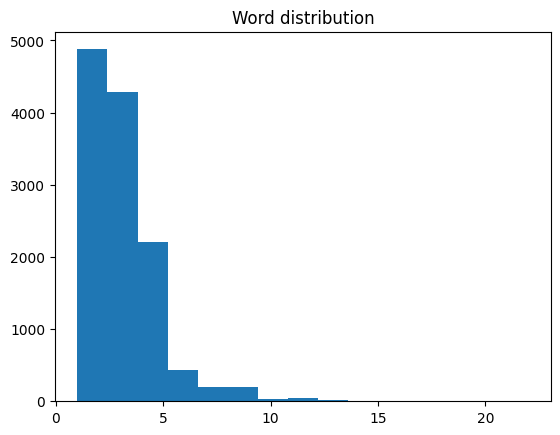

In [125]:

#config vec dim.
vector_size = 300
max_seq_len = 5


w2v_model = word2vec.Word2Vec(
    tokenized_train_features,
    vector_size=vector_size,  # Dimensionality of the word vectors
    window=7,
    min_count=1,
    sg=1  # 1 for skip-gram; otherwise CBOW
)
print(w2v_model)
w2v_model.save("word2vec_model.bin")

vocab_list = list(w2v_model.wv.key_to_index.keys())
def remove_OOV_vocab(sample: list, list_vocab):
    """ Takes in tokenized sample in the form of list 
    and the vocabulary list and removes tokens from sample
    that are not in the vocabulary list"""
    in_vocab_sample = []
    for each_token in sample:
        if each_token in list_vocab:
            in_vocab_sample.append(each_token)
    return in_vocab_sample
  
tokenized_test_features = [remove_OOV_vocab(each_test_sample, vocab_list) 
                           for each_test_sample in tokenized_test_features]


# Get the embedding matrix
# w2v_model is the word2vec model trained using Gensim

vocab = w2v_model.wv.key_to_index.keys()
embedding_matrix = w2v_model.wv[vocab]

print(())
print((embedding_matrix))
#print((vocab))
print(len(embedding_matrix[0,:]))

print(len(test_data["text"][0]))
a=[]
for i in range(len(test_data)):
    a=np.append(a,len(test_data["text"][i].split()))
plt.hist(a,bins=15)
plt.title("Word distribution")
plt.savefig("histo.png")
print("Total sum of words: ", np.sum(a))


In [118]:
def w2v_indexed_token_sequences(w2v_model, list_features):
    indexed_features = []
    for each_seq in list_features:
        list_token_indices = []
        for each_token in each_seq:
            try:
                list_token_indices.append(w2v_model.wv.key_to_index[each_token])
            except KeyError as e:
                continue
        indexed_features.append(list_token_indices)
    return indexed_features

indexed_train_features = w2v_indexed_token_sequences(w2v_model, tokenized_train_features)
indexed_test_features = w2v_indexed_token_sequences(w2v_model, tokenized_test_features)

padded_train = pad_sequences(indexed_train_features, padding = 'post', maxlen=max_seq_len, truncating='post')
padded_test = pad_sequences(indexed_test_features, padding = 'post', maxlen=max_seq_len, truncating='post')
print(padded_train)
print(np.shape(padded_train))
#expected input data shape: (batch_size, timesteps, data_dim
#reshape: datalle 128, 49178, 5

[[   49   214  6410   392  8608]
 [  227    35     0     0     0]
 [    1     0     5     0     0]
 ...
 [ 3134     0     0     0     0]
 [16132   108     0     0     0]
 [10192     2   633  3721     0]]
(49177, 5)


In [121]:
#from keras.layers import SimpleRNN not used
def get_model():
    model = Sequential()
    print(vector_size, "vecsize", np.shape(train_labels))
    print(len(vocab), max_seq_len, "kokoja")
    model.add(
        Embedding(input_dim=len(vocab),#vocab_size
                  output_dim=(vector_size),
                  weights=[embedding_matrix],
                  input_length=max_seq_len))

    model.add(Bidirectional(LSTM(128, input_shape = (49178,5), activation='relu',return_sequences=True)))
    model.add(Dropout(0.4)) #Avoid overfitting by randomly dropping.
    model.add(Bidirectional(LSTM(64, return_sequences=True))) 
    model.add(LSTM(num_cat*2, return_sequences=False))  # return a single vector of dimension 32
    model.add(Dense(num_cat, activation='softmax'))
    model.summary()
    return model
print("number of categories", num_cat)
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_train),y = y_train)
# Convert class weights to dictionary format
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print([round(val,1) for val in class_weights])

# Adding callbacks for best model checkpoint
callbacks = [
    keras.callbacks.EarlyStopping(monitor="accuracy",
                                  patience=3,
                                  verbose=1,
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='models/lstm_with_w2v.hdf5',
                                    verbose=1,
                                    save_best_only=True)
]
print(num_cat)
model = get_model()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

#tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
# storing model training details to analyze later
history = model.fit(padded_train,
                    train_labels,
                    batch_size=160, # 32
                    validation_split=0.33,
                    callbacks=callbacks,
                    epochs= 50,
                    class_weight=class_weights_dict)
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
# Save the model with the current timestamp in the filename
filename = f"my_model_{timestamp}.h5"
model.save(filename)

number of categories 11
[0.3, 0.4, 0.8, 0.9, 1.9, 2.1, 2.9, 3.1, 3.2, 4.3, 5.2]
11
300 vecsize (49177, 11)
18443 5 kokoja
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 5, 300)            5532900   
                                                                 
 bidirectional_60 (Bidirect  (None, 5, 256)            439296    
 ional)                                                          
                                                                 
 dropout_5 (Dropout)         (None, 5, 256)            0         
                                                                 
 bidirectional_61 (Bidirect  (None, 5, 128)            164352    
 ional)                                                          
                                                                 
 lstm_92 (LSTM)              (None, 22)                13288   

C:\Users\koistkos\jupyterlab_files\env\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


206/206 [==============================] - ETA: 0s - loss: 1.6682 - accuracy: 0.4558
Epoch 1: val_loss improved from inf to 1.24190, saving model to models\lstm_with_w2v.hdf5
206/206 [==============================] - 88s 429ms/step - loss: 1.6682 - accuracy: 0.4558 - val_loss: 1.2419 - val_accuracy: 0.6218
Epoch 2/50


C:\Users\koistkos\jupyterlab_files\env\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


206/206 [==============================] - ETA: 0s - loss: 1.0556 - accuracy: 0.6725
Epoch 2: val_loss improved from 1.24190 to 1.09982, saving model to models\lstm_with_w2v.hdf5
206/206 [==============================] - 102s 494ms/step - loss: 1.0556 - accuracy: 0.6725 - val_loss: 1.0998 - val_accuracy: 0.6616
Epoch 3/50
206/206 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.7666
Epoch 3: val_loss did not improve from 1.09982
206/206 [==============================] - 96s 467ms/step - loss: 0.7291 - accuracy: 0.7666 - val_loss: 1.1335 - val_accuracy: 0.6619
Epoch 4/50
206/206 [==============================] - ETA: 0s - loss: 0.5688 - accuracy: 0.8111
Epoch 4: val_loss did not improve from 1.09982
206/206 [==============================] - 98s 477ms/step - loss: 0.5688 - accuracy: 0.8111 - val_loss: 1.1463 - val_accuracy: 0.6631
Epoch 5/50
206/206 [==============================] - ETA: 0s - loss: 0.4866 - accuracy: 0.8288
Epoch 5: val_loss did not improve fr

In [122]:
#Get the score card
model_with_w2v = load_model("models/lstm_with_w2v.hdf5")
y_pred_one_hot_encoded = (model_with_w2v.predict(padded_train)> 0.5).astype("int32")
y_pred_train = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))
y_pred_one_hot_encoded = (model_with_w2v.predict(padded_test)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))

# Training set
print("--------------------------------------------------")
print("Training set")
print(classification_report(train_data['teksti_label'], y_pred_train))
# Test Set
print("--------------------------------------------------")
print("Test set")
print(classification_report(test_data['teksti_label'], y_pred_test))

385/385 [==============================] - 40s 105ms/step
--------------------------------------------------
Training set
              precision    recall  f1-score   support

           0       0.63      0.89      0.74     16146
           1       0.90      0.67      0.77     11368
           2       0.80      0.54      0.65      5806
           3       0.86      0.41      0.55      5149
           4       0.70      0.60      0.65      2310
           5       0.84      0.66      0.74      2115
           6       0.41      0.58      0.48      1534
           7       0.65      0.84      0.73      1451
           8       0.48      0.76      0.59      1402
           9       0.90      0.91      0.91      1030
          10       0.72      0.58      0.64       866

    accuracy                           0.70     49177
   macro avg       0.72      0.68      0.68     49177
weighted avg       0.75      0.70      0.70     49177

--------------------------------------------------
Test set
     

[1.2419041395187378, 1.0998210906982422, 1.1334649324417114, 1.1463148593902588, 1.192182183265686, 1.1500543355941772, 1.2110846042633057, 1.2251960039138794, 1.2397886514663696, 1.272763729095459, 1.281205177307129, 1.2584669589996338, 1.3274171352386475, 1.337303638458252, 1.3494020700454712, 1.4222279787063599, 1.3837376832962036, 1.382767677307129, 1.4022417068481445, 1.4319119453430176, 1.3905223608016968, 1.4429595470428467, 1.4448256492614746, 1.4301966428756714, 1.5050336122512817, 1.5223318338394165, 1.517441749572754, 1.5482860803604126, 1.5169341564178467, 1.5551131963729858, 1.5978413820266724, 1.602174162864685, 1.6142234802246094, 1.5867820978164673, 1.6102445125579834, 1.6781744956970215, 1.616530179977417, 1.7004971504211426, 1.6901524066925049, 1.6762467622756958, 1.7017568349838257, 1.7060943841934204, 1.735396146774292, 1.696053385734558, 1.7275731563568115, 1.6961082220077515, 1.7432544231414795, 1.7725473642349243, 1.7703951597213745, 1.8060617446899414]
(array([0

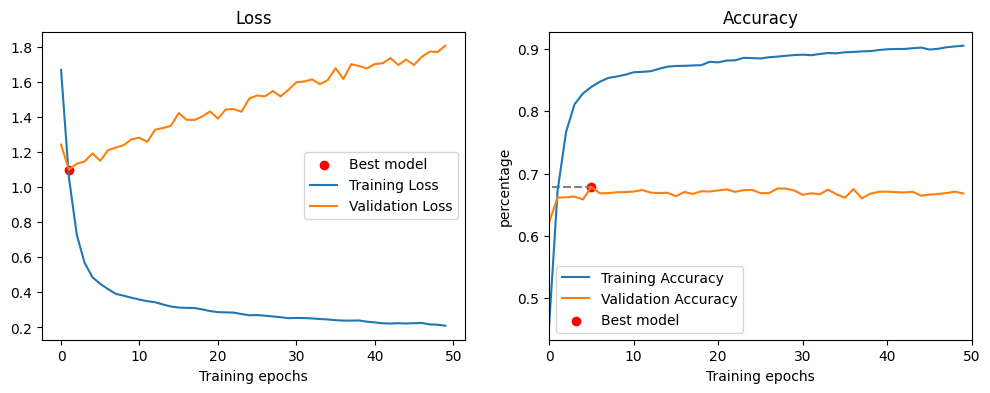

In [123]:
    #Get the history
    print(history.history['val_loss'])
    plt.figure(figsize=(12, 4))
    print(np.where(history.history['loss']==np.max(history.history['loss'])))
    plt.subplot(1, 2, 1)
    print(np.min(history.history['val_loss']), np.where(history.history['loss']==np.max(history.history['loss'])))
    plt.scatter(np.where(history.history['val_loss']==np.min(history.history['val_loss'])),
                np.min(history.history['val_loss']), color = "red", label="Best model", zorder=2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel("Training epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.scatter(np.where(history.history['val_accuracy']==np.max(history.history['val_accuracy'])),np.max(history.history['val_accuracy']), color = "red", label="Best model")
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel("Training epochs")
    plt.ylabel("percentage")
    plt.hlines(np.max(history.history['val_accuracy']), -1,
               np.where(history.history['val_accuracy']==np.max(history.history['val_accuracy'])),
               color="grey", linestyle="dashed",zorder=1)
    plt.xlim(0,len(history.history['val_accuracy']))
    plt.savefig("Loss_accuracy" + datetime.now().strftime("%H%M%S")+".png",dpi=600)
    plt.show()

['Käyttöoikeudet', 'Järjestelmäpalvelut', 'Työasemasovellus', 'Työasemat', 'Oheislaitteet', 'Mobiililaite', 'Muut', 'Puhelinpalvelut', 'Etäyhteydet', 'Elinkaari', 'Tietoliikenne']


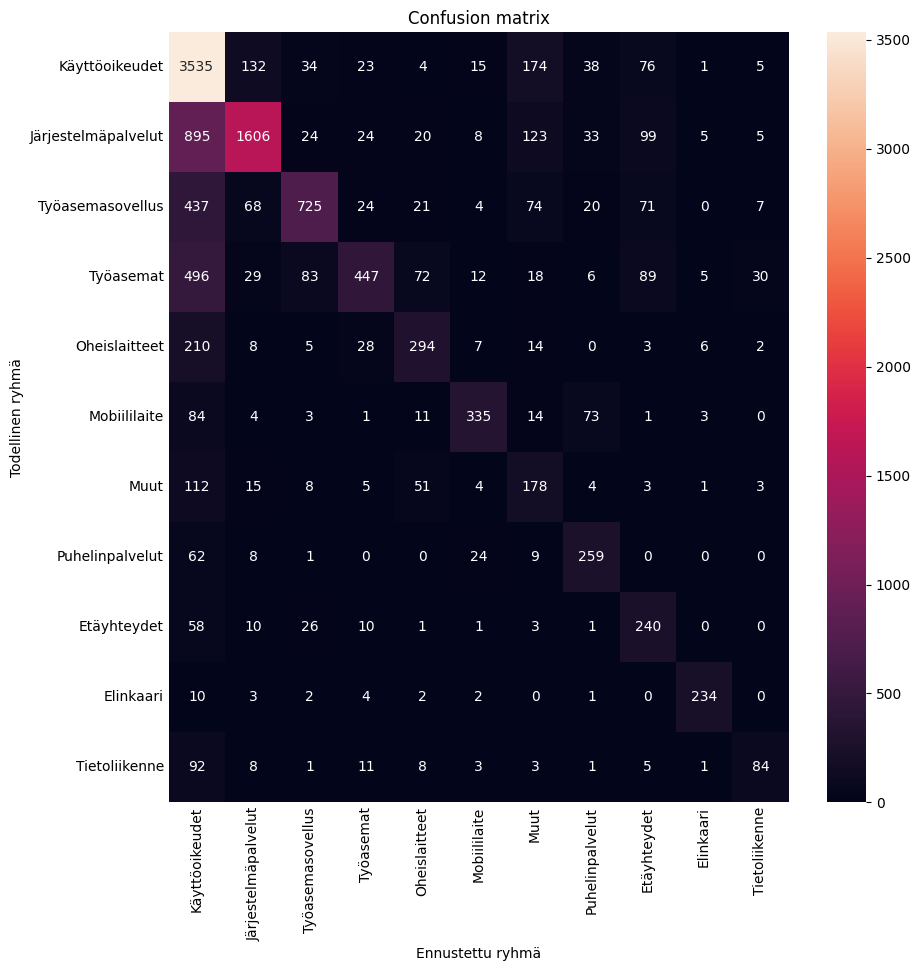

In [124]:
#Confusion matrix!

model_with_w2v = load_model("models/lstm_with_w2v.hdf5")
#Chat gpt instructions:

y_pred_classes = y_pred_test
y_test_classes = test_data['teksti_label']

cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix for better visualization
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Todellinen ryhmä')
plt.xlabel('Ennustettu ryhmä')
print(categorynames)
plt.tick_params(axis='both', which='both', length=0)
plt.xticks(np.arange(0.5,len(categorynames)+0.5),categorynames,rotation=90)
plt.yticks(np.arange(0.5,len(categorynames)+0.5),categorynames, rotation=0)
plt.savefig("Confusion matrix" + datetime.now().strftime("%H%M%S")+".png",dpi=600,bbox_inches='tight')
plt.show()

In [22]:
# Test. Not at work here. You can test it in another file ("TEST_THE_MODEL.ipynb")!
sentence = input("Syötä testilause").lower()
tokens = word_tokenize(sentence)
print("Testattava lause:", sentence)
#print(tokens)
tokens = np.array(tokens)
tokens = tokens.reshape(1,-1)
indexed_test_features = w2v_indexed_token_sequences(w2v_model, tokens)
padded_test = pad_sequences(indexed_test_features, padding = 'post', maxlen=max_seq_len, truncating='post')

predictions = model_with_w2v.predict(padded_test)
print("predictions percent", np.round(100*predictions,2))
print(np.shape(predictions))

categ = copy.deepcopy(categorynames)
print(categ)
print("ENNUSTE: Kuuluu ryhmään ", np.argmax(predictions), "" , categ[np.argmax(predictions)] , " todennäköisyydellä ", 
      round(100*predictions[0,np.argmax(predictions)],2),"%")

Syötä testilause Tietokone on rikki


Testattava lause: tietokone on rikki


NameError: name 'w2v_indexed_token_sequences' is not defined